# Install and import packages



We’ll use two main tools:
- CELLxGENE Census to fetch public data (so we don't have to download giant files onto our computer)
- Scanpy to analyze data (https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

In [ ]:
!pip install -q scanpy cellxgene-census anndata matplotlib igraph


In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cellxgene_census

# Explore the census
- For the rest of the notebook, we will just look at another dataset, but just to show an example, if you wanted to pull the metadata for all of the datasets in the census in humans with Alzheimer's disease, you could do so with code like below.


In [ ]:
# with cellxgene_census.open_soma() as census:

#     # Reads SOMADataFrame as a slice
#     cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
#         value_filter = "disease in ['Alzheimer disease']",
#         column_names = ["assay", "cell_type", "tissue", "tissue_general",
#                         "suspension_type", "disease", "dataset_id"]
#     )

#     # Concatenates results to pyarrow.Table
#     cell_metadata = cell_metadata.concat()

#     # Converts to pandas.DataFrame
#     cell_metadata = cell_metadata.to_pandas()

#     print(cell_metadata)

# Download dataset of interest
- Immune cells from: https://cellxgene.cziscience.com/collections/77f9d7e9-5675-49c3-abed-ce02f39eef1b



In [ ]:
with cellxgene_census.open_soma() as census:

    # Reads SOMADataFrame as a slice
    cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "dataset_id == 'e522d2cd-7927-4e59-a4ed-064009569279'",
        column_names = ["assay", "cell_type", "tissue", "tissue_general",
                        "suspension_type", "disease", "dataset_id", "sex",
                        "donor_id", "soma_joinid"]
    )

    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

    print(cell_metadata)

The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.


             assay                                          cell_type tissue  \
0        10x 3' v3                           mucosal invariant T cell  blood   
1        10x 3' v3  naive thymus-derived CD4-positive, alpha-beta ...  blood   
2        10x 3' v3    CD14-positive, CD16-negative classical monocyte  blood   
3        10x 3' v3     central memory CD4-positive, alpha-beta T cell  blood   
4        10x 3' v3    CD14-positive, CD16-negative classical monocyte  blood   
...            ...                                                ...    ...   
1821720  10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   
1821721  10x 3' v3  naive thymus-derived CD4-positive, alpha-beta ...  blood   
1821722  10x 3' v3                            naive regulatory T cell  blood   
1821723  10x 3' v3                                      memory B cell  blood   
1821724  10x 3' v3     central memory CD4-positive, alpha-beta T cell  blood   

        tissue_general suspension_type 

In [ ]:
# get some stats about the data

print("Total cells:", len(cell_metadata))
print("Cell types:", len(cell_metadata["cell_type"].unique()))

print("Sex counts:")
print(cell_metadata["sex"].value_counts())

print("Donor ids:", len(cell_metadata["donor_id"].unique()))

Total cells: 1821725
Cell types: 38
Sex counts:
sex
female     989244
male       832481
unknown         0
Name: count, dtype: int64
Donor ids: 108


In [ ]:
# randomly downsample to 50k cells for memory purposes
n_cells = 50000
sampled_obs = cell_metadata.sample(n_cells, random_state=42)
sampled_cell_ids = sampled_obs["soma_joinid"].tolist()

# look at sex distribution in downsampled as an example
print(sampled_obs["sex"].value_counts())


sex
female     27208
male       22792
unknown        0
Name: count, dtype: int64


In [ ]:
# Get object (will take a few minutes)
with cellxgene_census.open_soma() as census:
  adata = cellxgene_census.get_anndata(
      census,
      organism="Homo sapiens",
      obs_coords=sampled_cell_ids,      # randomly subsampled 50k cells
      obs_column_names=[
          "soma_joinid",
          "dataset_id",
          "assay",
          "cell_type",
          "sex",
          "donor_id",
          "disease",
          "tissue",
          "tissue_general",
      ],
      var_column_names=["soma_joinid", "feature_id",
                        "feature_name", "feature_length"],
  )

# make gene names the var index
adata.var_names = adata.var["feature_name"]
adata.obs_names = adata.obs["soma_joinid"].astype(str)

# print out the object
adata


The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.
/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 50000 × 61497
    obs: 'soma_joinid', 'dataset_id', 'assay', 'cell_type', 'sex', 'donor_id', 'disease', 'tissue', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

## Preprocessing  
- Quality Control
- Normalization
- Identify highly variable features
- Dimensional Reduction

In [ ]:
adata.var
len(adata.var["feature_name"].unique())
# have some duplicate gene names so have to do this
adata.var_names_make_unique()

/tmp/ipython-input-3246169212.py:4: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`. Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  adata.var_names_make_unique()


## Preprocessing: Quality Control

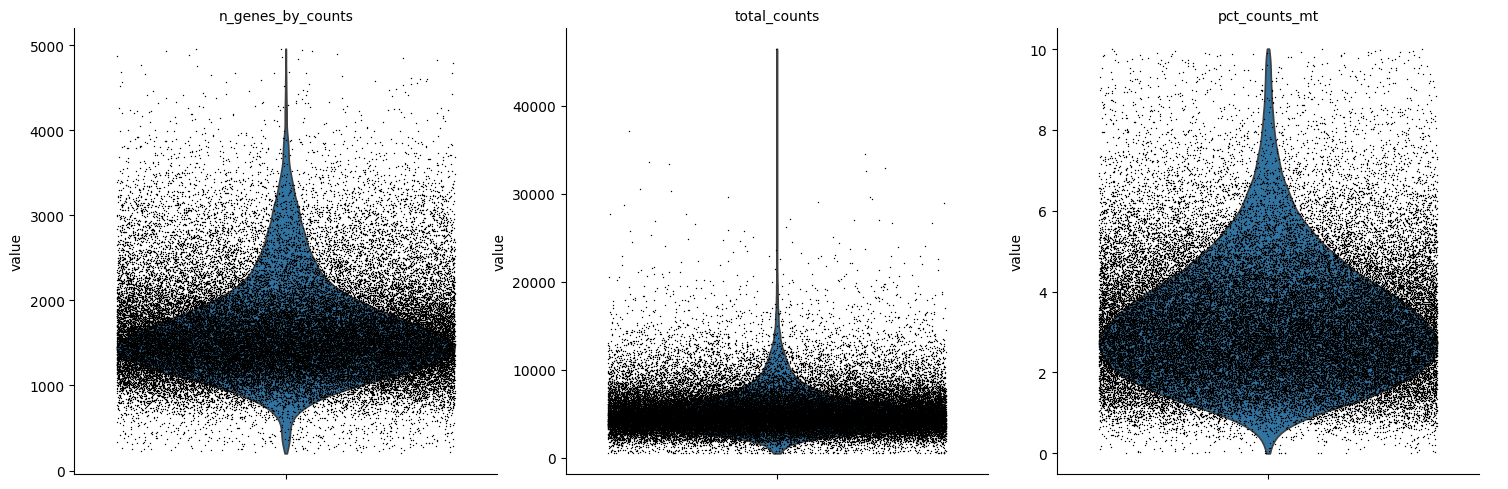

In [ ]:
# mark mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# calculate qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

# plot
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


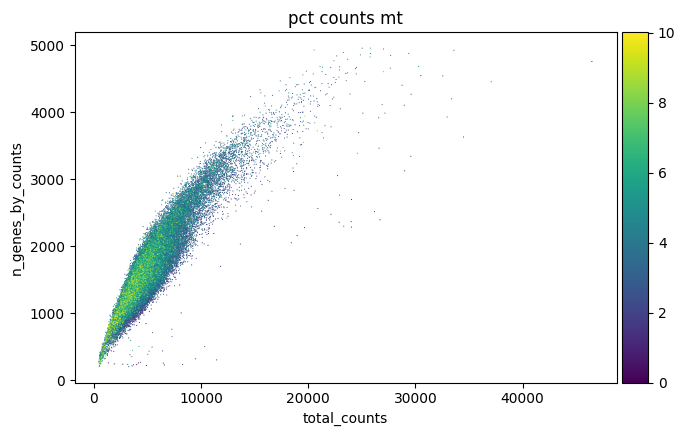

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [ ]:
# Filter out low quality cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# look at object after filtering, only features were filtered cause we already filtered cells
adata

AnnData object with n_obs × n_vars = 50000 × 21892
    obs: 'soma_joinid', 'dataset_id', 'assay', 'cell_type', 'sex', 'donor_id', 'disease', 'tissue', 'tissue_general', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [ ]:
# Optionally, identify doublets:
# sc.pp.scrublet(adata, batch_key="sample")

## Preprocessing: Normalization

In [ ]:
# Save counts
adata.layers["counts"] = adata.X.copy()
# Normalize library size
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Preprocessing: Feature Selection

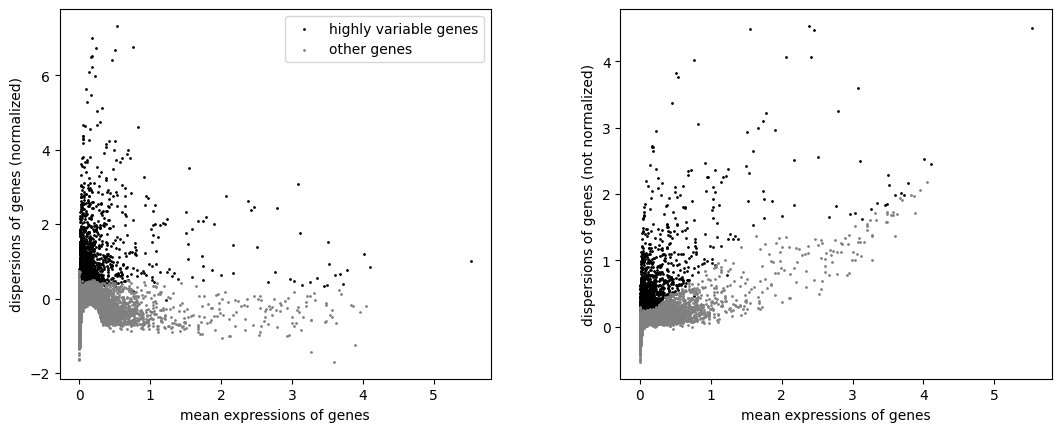

In [ ]:
# essentially, identify informative genes as those that are variable
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="donor_id")
sc.pl.highly_variable_genes(adata)



## Preprocessing: Dimensionality Reduction with PCA

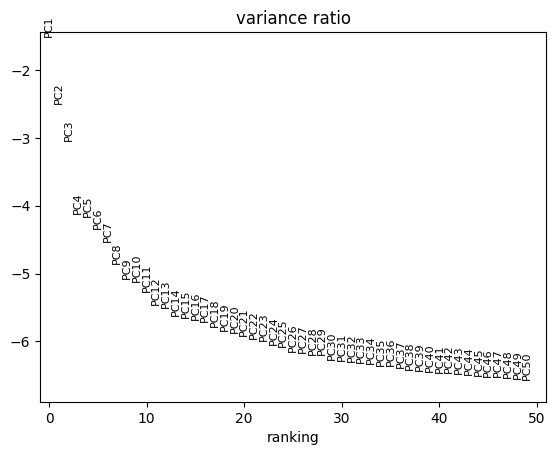

In [ ]:
sc.tl.pca(adata)
# elbow plot
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [ ]:
# function to consolidate the cell types we have
# just to make it easier to interpret results

def map_to_broad_cell_type(label: str) -> str:
    if label is None:
        return "Other"

    s = str(label).lower()

    # T regs
    if "regulatory t cell" in s or "treg" in s:
        return "Regulatory T cell"

    # CD8 vs CD4 T cells
    elif "cd8" in s and "t cell" in s:
        return "CD8 T cell"
    elif "cd4" in s and "t cell" in s:
        return "CD4 T cell"

    # Generic T / thymocyte
    elif "thymocyte" in s:
        return "Thymocyte / developing T cell"
    elif " t cell" in s or s.startswith("t cell"):
        return "T cell"

    # NK
    elif "natural killer cell" in s:
        return "NK cell"

    # B lineage
    elif "plasma cell" in s:
        return "Plasma cell"
    elif "b cell" in s or s.startswith("be cell"):
        return "B cell"

    # Monocytes
    elif "monocyte" in s:
        return "Monocyte"

    # Dendritic cells
    elif "dendritic cell" in s or "dc" in s:
        return "Dendritic cell"

    # Progenitors
    elif "progenitor" in s:
        if "myeloid" in s:
            return "Myeloid progenitor"
        if "lymphoid" in s:
            return "Lymphoid progenitor"
        if "basophil" in s or "mast" in s:
            return "Basophil/mast progenitor"
        return "Progenitor"

    # Platelets / RBCs
    elif "platelet" in s:
        return "Platelet"
    elif "erythrocyte" in s or "red blood cell" in s:
        return "Erythrocyte"

    # Fallback: keep original label
    return str(label)


In [ ]:
adata.obs["cell_type_broad"] = adata.obs["cell_type"].apply(map_to_broad_cell_type)
adata.obs["cell_type_broad"].value_counts()

,count
cell_type_broad,
CD4 T cell,19353
Monocyte,8994
CD8 T cell,8335
B cell,4283
NK cell,4010
T cell,2657
Regulatory T cell,1082
Dendritic cell,647
Platelet,242


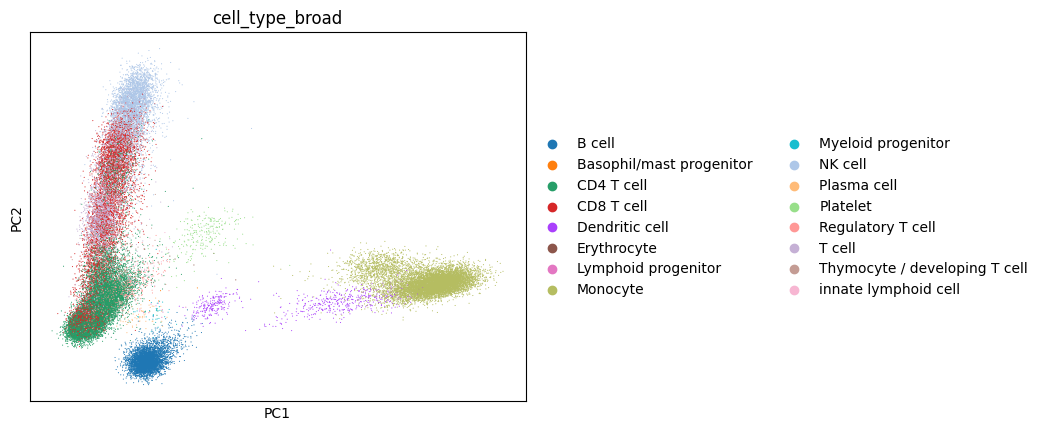

In [ ]:
# color PCA by celltype and sex and donor id
sc.pl.pca(adata, color=["cell_type_broad"])

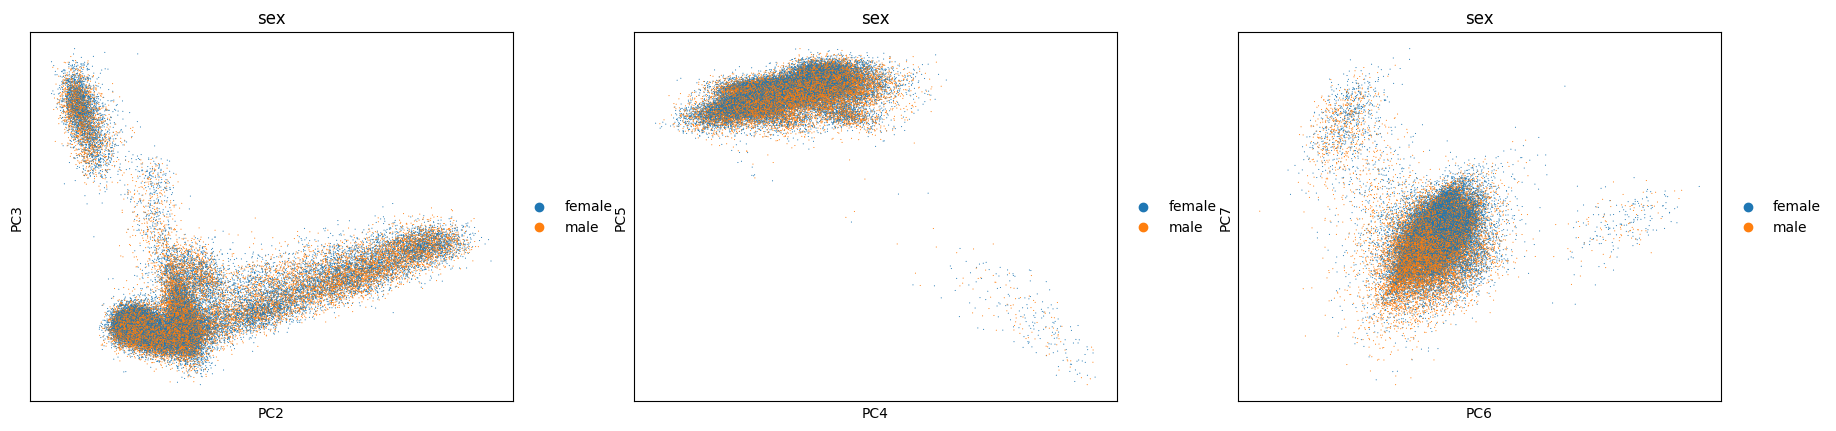

In [ ]:
sc.pl.pca(adata, color=["sex"], dimensions=[(1,2), (3, 4), (5, 6)])
# sex seems to be most prominet in pc6/7


In [ ]:
# cluster and see how it compares to the celltypes we already have

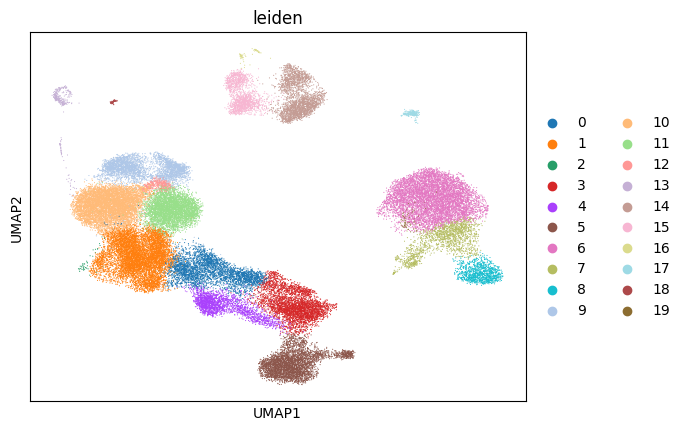

In [ ]:
# build neighbor graph
sc.pp.neighbors(adata)
# run umap
sc.tl.umap(adata)
# get clusters
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 1)
# visualize clusters on umap
sc.pl.umap(adata, color=["leiden"])


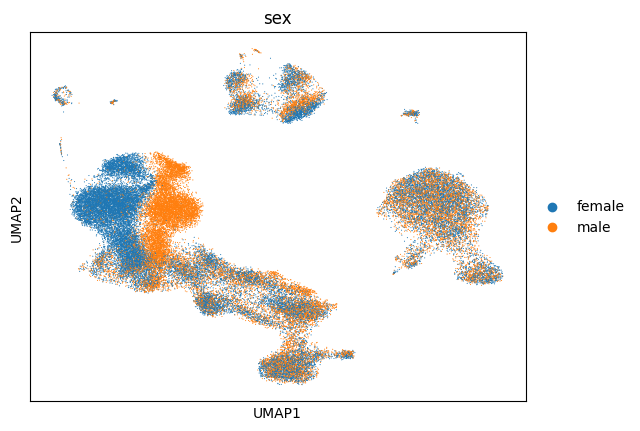

In [ ]:
sc.pl.umap(adata, color=["sex"])


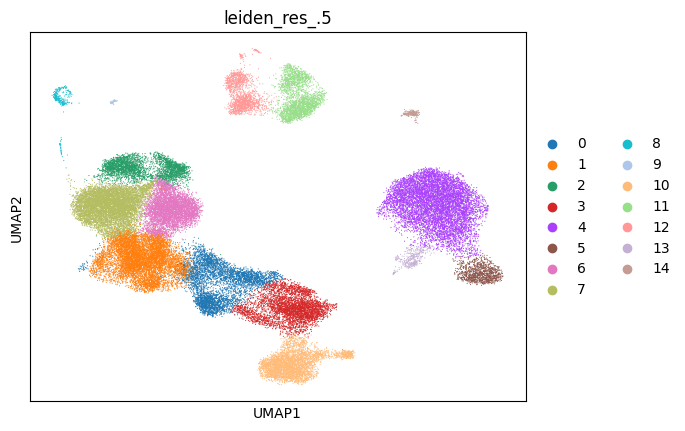

In [ ]:
# clustering with a different resolution
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5, key_added= "leiden_res_.5")
sc.pl.umap(adata, color=["leiden_res_.5"])

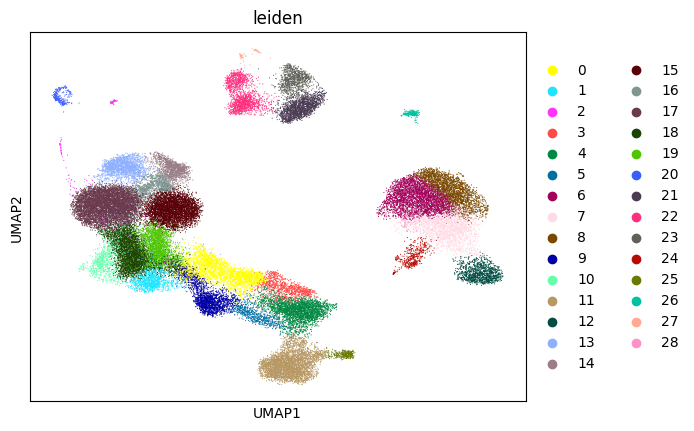

In [ ]:
# clustering with a different resolution
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 2)
sc.pl.umap(adata, color=["leiden"])

## Analysis: Differential expression between cell types
- Just going to use the provided cell types for this, but you could assign cell types to clusters yourself



In [ ]:
# Differential expression between all cell types
sc.tl.rank_genes_groups(adata, groupby='cell_type_broad', method='wilcoxon')

In [ ]:
# example of output
df = sc.get.rank_genes_groups_df(adata, key="rank_genes_groups",
                                 group = "CD8 T cell")
df

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD8B,116.128029,5.977100,0.0,0.0
1,CD8A,104.005249,4.815226,0.0,0.0
2,CD3D,71.395920,1.555180,0.0,0.0
3,CD3G,67.991516,1.497581,0.0,0.0
4,IL32,67.835747,1.686253,0.0,0.0
...,...,...,...,...,...
21887,C1orf162,-43.506355,-1.549358,0.0,0.0
21888,TYROBP,-43.726810,-3.220430,0.0,0.0
21889,S100A11,-44.481754,-1.326582,0.0,0.0
21890,RNASET2,-47.898640,-1.330635,0.0,0.0


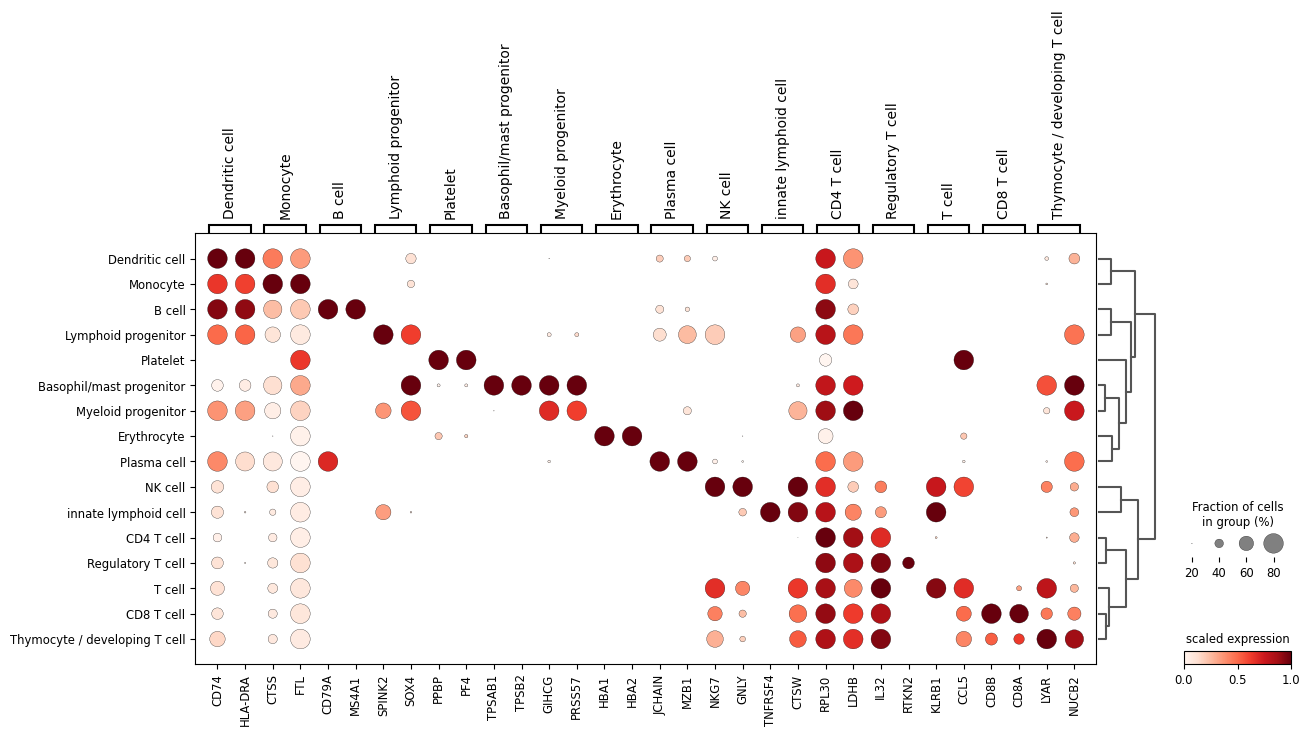

In [ ]:
# Dot plot of top 2 genes per cell type
sc.pl.rank_genes_groups_dotplot(adata, groupby='cell_type_broad',
                                standard_scale='var',
                                colorbar_title='scaled expression',
                                dot_max=0.8, dot_min=0.2,
                                n_genes=2)

##### all done for now! go to UofT_human_immune_atlas_CD8T.ipynb for a deeper dive into a specific cell type DE analysis

##### for more information on single cell analysis steps like clustering and manual cell type annotation: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html